In [1]:
# Import NetworkX and key data science libraries
import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme()

In [2]:
edges = pd.read_csv("quaker-edges.csv")
edges

FileNotFoundError: [Errno 2] No such file or directory: 'quaker-edges.csv'

In [3]:
nodes = pd.read_csv("quaker-nodes.csv")
nodes

,Id,Label,historical significance,gender,birthdate,deathdate,other_id
0,George Keith,George Keith,Quaker schismatic and Church of England clergyman,male,1638,1716,10006784
1,Robert Barclay,Robert Barclay,religious writer and colonial governor,male,1648,1690,10054848
2,Benjamin Furly,Benjamin Furly,merchant and religious writer,male,1636,1714,10004625
3,Anne Conway Viscountess Conway and Killultagh,Anne Conway Viscountess Conway and Killultagh,philosopher,female,1631,1679,10002755
4,Franciscus Mercurius van Helmont,Franciscus Mercurius van Helmont,physician and cabbalist,male,1614,1698,10005781
...,...,...,...,...,...,...,...
91,Elizabeth Leavens,Elizabeth Leavens,Quaker missionary,female,1555,1665,10007246
92,Lewis Morris,Lewis Morris,politician in America,male,1671,1746,10008534
93,Sir Charles Wager,Sir Charles Wager,naval officer and politician,male,1666,1743,10012403
94,William Simpson,William Simpson,Quaker preacher,male,1627,1671,10011114


In [4]:
quakers = nx.from_pandas_edgelist(edges, source="Source", target="Target")
print(quakers)

Graph with 96 nodes and 162 edges


In [5]:
p = nodes.groupby("gender").count().Id["male"]/nodes.count().Id
p

0.84375

In [6]:
q = nodes.groupby("gender").count().Id["female"]/nodes.count().Id
q

0.15625

In [7]:
2*p*q

0.263671875

In [8]:
nx.set_node_attributes(quakers, dict(zip(nodes.Id, nodes.gender)), 'gender')

In [9]:
mixed_edges = len([(s,t) for s,t in quakers.edges if quakers.nodes[s]['gender'] != quakers.nodes[t]['gender']])
mixed_edges

32

In [10]:
mixed_edges/quakers.number_of_edges()

0.19753086419753085

In [31]:
def homophily(mixed_edges):
    return 2*p*q - mixed_edges/quakers.number_of_edges()

In [32]:
obs_homophily = homophily(mixed_edges)
obs_homophily

0.06614101080246915

In [16]:
def simulate_mixed_edges(data, attribute, id_attr, graph):
    attr_column = data[attribute].sample(frac=1).reset_index(drop=True) # Reshuffle column
    nx.set_node_attributes(graph, dict(zip(data[id_attr], attr_column)), attribute) # Set node attribute
    mixed_edges = len([(s,t) for s,t in graph.edges if graph.nodes[s][attribute] != graph.nodes[t][attribute]]) # Get number of mixed edges
    return mixed_edges

In [33]:
sim_homophily = pd.Series([homophily(simulate_mixed_edges(nodes, 'gender', 'Id', quakers)) for i in range(5000)])
sim_homophily

0       0.097005
1      -0.094353
2       0.041450
3       0.109351
4       0.066141
          ...   
4995   -0.082007
4996   -0.038797
4997    0.022931
4998    0.022931
4999    0.016758
Length: 5000, dtype: float64

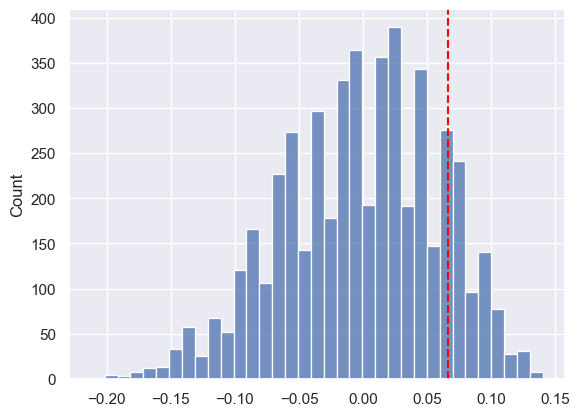

In [34]:
plt = sns.histplot(x=sim_homophily)
plt.axvline(x=obs_homophily, color="red", ls="--")

In [35]:
p_value = np.mean(sim_homophily > obs_homophily)
p_value

0.124